In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import sys
sys.path.insert(0, '..')
from Elastic import plate_fem as pt
from Fluid.Fluid_gpu import Fluid
from Fluid import F3D
import numpy as np
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
import fenics as fe
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve

# Specify geometry
aspect_ratio = 10
l_c = 500e-6  # length of beam in m
h_c = 5e-6  # thickness of the beam in m
w_c = l_c / aspect_ratio  # width in m

# Specify fluid -> Water
mu_f = 890e-6  # Fluid dynamic viscosity in Pa.s
rho_f = 997  # Fluid density in kg/m^3
nu_f = mu_f / rho_f  # Fluid kinematic viscosity in m^2/s

# Specify material of plate -> Silicon
e_c = 169E9  # Young's Modulus in Pa
rho_c = 2.33E3  # Density in kg/m^3
nu_c = 0.3  # Poisson Coefficient, dimensionless

# Basic objects, shared by all classes
geometry = pt.Geometry(l_c, w_c, h_c)
mat = pt.Material(e_c, rho_c, nu_c)
fluid = Fluid(mu_f, rho_f)

# Mesh specification -> To solve Kirchhoff-Love plate equation
n_x = 32  # Number of elements in length l_c (x-direction)
n_y = int(n_x/aspect_ratio) # Number of elements in width w_c (y-direction)

# Fluid grid specification -> To solve the fluid problem
n_x_fluid = 24  # Number of elements in length l_c (x-direction)
n_y_fluid = int(2*n_x_fluid)  # Number of elements in width w_c (y-direction)





Isotropic material


In [2]:
plate = pt.Kirchhoff()
plate.geometry = geometry
plate.mat = mat
plate.meshing(n_x, n_y, 'crossed')
plate.preliminary_setup()
plate.k_and_m_matrices()
#plate.setup_eigenvalues_problem()

Isotropic material

 Setup Mesh 32 x 3.

 Setup Mesh 32 x 3.


(<dolfin.cpp.la.PETScMatrix at 0x7f136b9c3a10>,
 <dolfin.cpp.la.PETScMatrix at 0x7f136b9c2cf0>)

In [3]:
vfi = F3D.F3D()
vfi.fluid = fluid
vfi.fem = plate
vfi.geometry = geometry
vfi.setup_quadrature(n_x_fluid, n_y_fluid, x_uniform=True)
vfi.tol_stk=2e-3

Isotropic material


# Solve for VFI dynamics in the frequency domain

In [4]:

# Spectral analysis
n_f = 150  # Number of steps in frequency
f_initial = 1e3  # Specify Initial frequency in Hz
f_final = 500e3  # Specify Final frequency in Hz, you can use the f_n in vacuum as an initial guess
#frequency = np.linspace(f_initial, f_final, n_f, endpoint=True)
frequency = np.logspace(np.log10(f_initial), np.log10(f_final), n_f, endpoint=True)


In [5]:
row, col, val = fe.as_backend_type(plate.m_matrix.mat().getValuesCSR())
M_csr = sp.csr_matrix((val, col, row), dtype=complex)

row, col, val = fe.as_backend_type(plate.k_matrix.mat().getValuesCSR())
K_csr = sp.csr_matrix((val, col, row), dtype=complex)

L = np.array(plate.get_linear_form())

phi_3d = np.zeros(len(frequency), dtype=complex)

In [6]:
tt = time.time()
for ff in tqdm(range(n_f)):
    omega = 2*np.pi*frequency[ff]
    Fl_3d = vfi.get_p_force(omega)
    L_2d = K_csr - omega**2*M_csr + 1j*omega*Fl_3d
    phi = spsolve(L_2d, L)
    phi_3d[ff] = plate.get_point_value(phi)


100%|██████████| 150/150 [09:06<00:00,  3.64s/it]


# Compare to Sader

In [7]:
import Fluid.Analytic as Sader

probe = Sader.SaderMethod()
# specify geometry
probe.geometry = geometry
probe.fluid = fluid
probe.mat = mat
probe.frequency = frequency
probe.N_modes = 10
probe.n_x = 200
#w = probe.thermal_displacement()
#q_sader = probe.q_factor()
w = probe.get_displacement_per_force().T*w_c
w_sader = w


Isotropic material


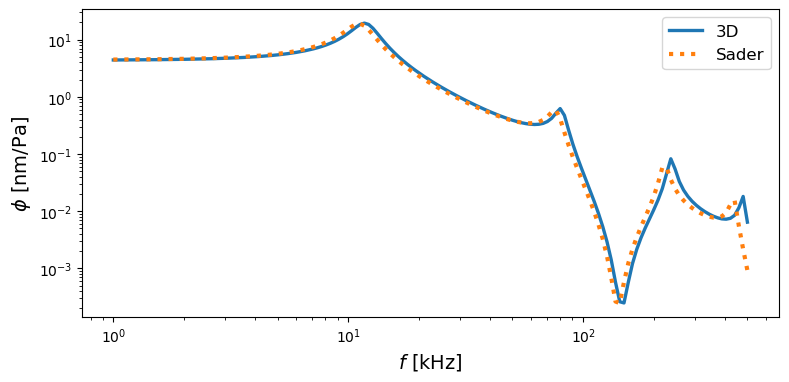

In [8]:
plt.figure(1, figsize=(9, 4))
plt.loglog(frequency/1e3, 1e9*np.abs(phi_3d), linewidth=2.4, label='3D')
plt.loglog(frequency/1e3, 1e9*np.abs(w_sader[:, -1]), ':', linewidth=3,  label='Sader')
#plt.loglog(frequency/1e3, np.abs(phi_probe), '--', label='Old')
plt.legend(fontsize=12)
plt.xlabel('$f$ [kHz]', fontsize=14)
plt.ylabel(r'$\phi$ [nm/Pa]', fontsize=14)
plt.show()

## Compare with non-uniform x-mesh
Non-uniform mesh means Chebyshev-Gauss quadrature means a more accurate pressure description in x-direction, which renders results slightly more accurate, although at the expense of performance. 

In [ ]:
vfi.setup_quadrature(n_x_fluid, n_y_fluid, x_uniform=False)
tt = time.time()
phi_non_uni = np.zeros(len(frequency), dtype=complex)
for ff in tqdm(range(n_f)):
    omega = 2*np.pi*frequency[ff]
    Fl_3d = vfi.get_p_force(omega)
    L_2d = K_csr - omega**2*M_csr + 1j*omega*Fl_3d
    phi = spsolve(L_2d, L)
    phi_non_uni[ff] = plate.get_point_value(phi)
    #pbar.update(1)
    #if ff == 0:
    #    tt = (time.time() - tt)*(n_f - 1)
    #    print('Estimated remaining time: %d minutes and %d seconds' %(np.floor(tt/60), tt%60))

  0%|          | 0/150 [00:00<?, ?it/s]  5%|▌         | 8/150 [03:55<1:00:11, 25.43s/it]

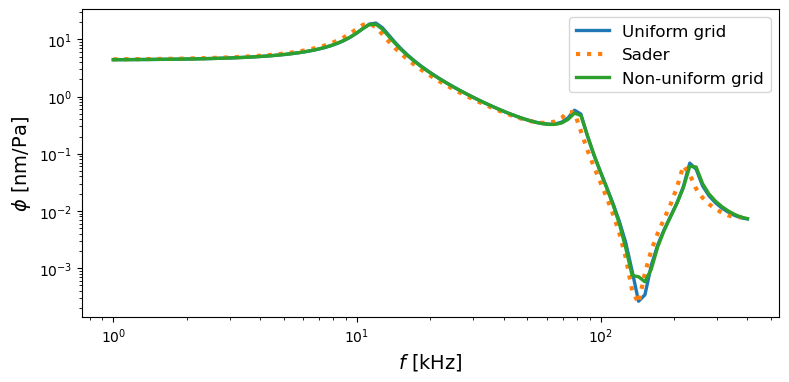

In [ ]:
plt.figure(1, figsize=(9, 4))
plt.loglog(frequency/1e3, 1e9*np.abs(phi_3d), linewidth=1.4, label='Uniform grid')
plt.loglog(frequency/1e3, 1e9*np.abs(w_sader[:, -1]), ':', linewidth=3,  label='Sader')
plt.loglog(frequency/1e3, 1e9*np.abs(phi_non_uni), linewidth=1.4, label='Non-uniform grid')
#plt.loglog(frequency/1e3, np.abs(phi_probe), '--', label='Old')
plt.legend(fontsize=12)
plt.xlabel('$f$ [kHz]', fontsize=14)
plt.ylabel(r'$\phi$ [nm/Pa]', fontsize=14)
plt.show()